This notebook was prepared by [Author](https://github.com/ankitksharma). Source and license info is on [GitHub](https://github.com/ankitksharma/interactive-coding-challenges).

# Solution Notebook

## Problem: 

### Implement Linear Regression model, which has a predict function which makes prediction on input data using **Tensor Flow** library

* [Constraints](#Constraints)
* [Algorithm](#Algorithm)
* [Code](#Code)

## Constraints

* Can we assume all predictor variable are numerical?
    * Yes
* Can we assume no missing value in data?
    * Yes
* Can we assume no outlier in data?
    * Yes

## Algorithm

### Polynomial Function
We will model our *unknown* function using this hypothesis function. 

$$h(x) = w_0 + w_1x + w_2x^2 + w_3x^3 + ... + w_px^p$$

We have to fix the $p$ before fitting the model. If $p=1$, we get a linear function. Which of course will not be sufficient to fit the dataset we have. We may have to set $p$ to some higher value like 5 or 6, which may have to be found emperically, by trying out different values.

However, for a fixed $p$, we can find the optimal choice of parameters $w_0, w_1, ..., w_p$, using gradient descent algorithm. Which is what we will implement in the following section.

Given dataset is of size (100, 2)


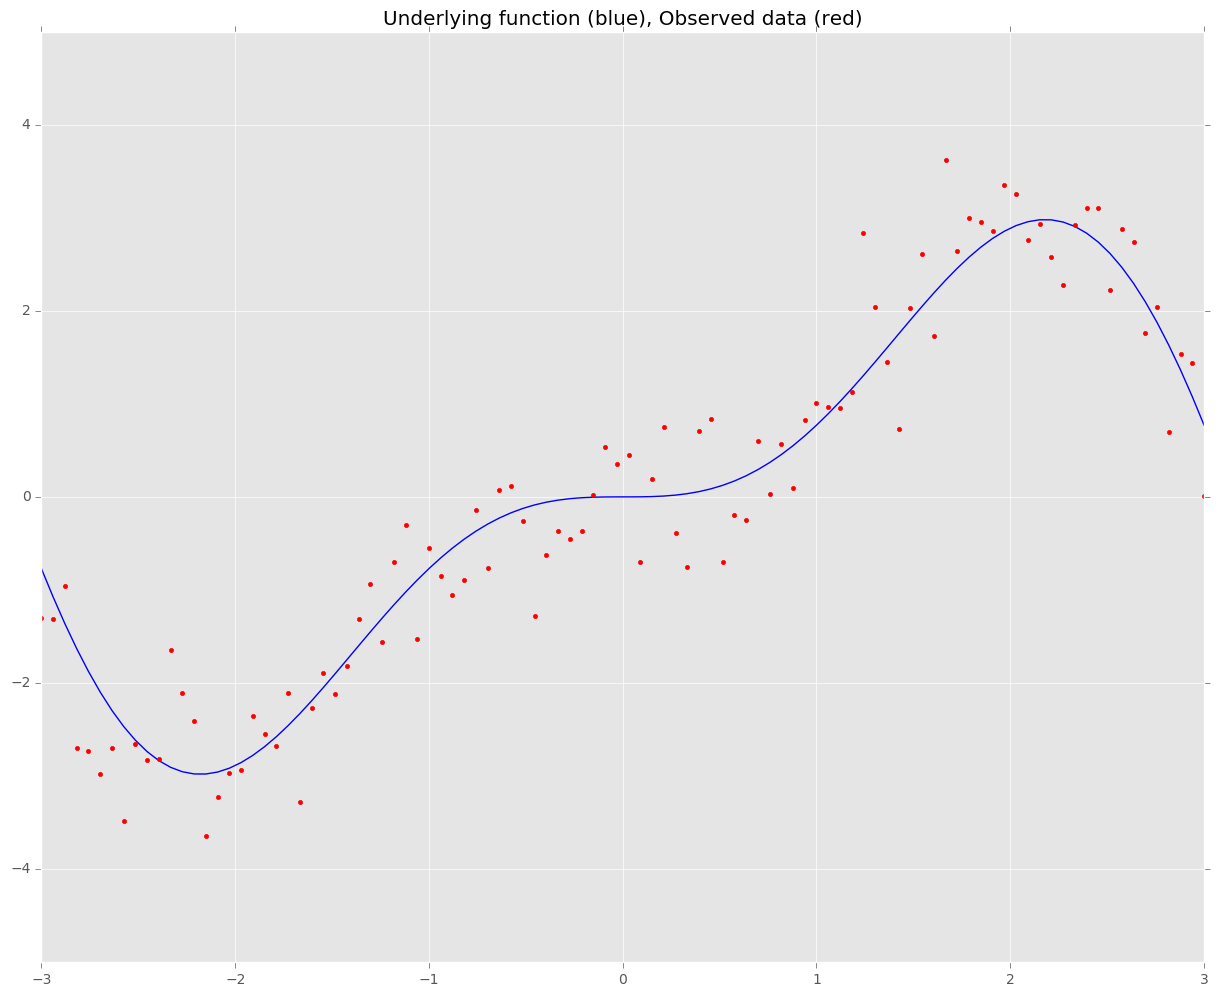

In [3]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
fig_size = [15, 12]
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('ggplot')

num_samples = 100
x = np.linspace(-3,3,num_samples)  #Create num_samples number of equally spaced values between -3 to +3
y_true = np.sin(x) - x*np.cos(1.5*x) 

"""
Above function is the true function we would like to approximate.
Note that the true underlying function won't be known in the real world application. 
We are synthetically generating the data here using some non linear function
"""

mean = 0 #By adding a random variable sampled from zero mean and a small standard deviation, we can generate noisy data
standard_deviation = 0.5 #You can vary the noise amount and see the effect on the data points
y_observed = y_true + np.random.normal(0, 0.5, y_true.size)

"""
The noisy version of the data is created in the above code, by adding gaussian noise to the original data.
Typically, this is what we observe, and our task is to build a model that best approximates the underlying true model.
Note again, that we DO NOT KNOW the form of the underlying model. One option for us is to assume that it CAN be 
modeled by a polynomial equation of the form y = w0 + w1*x + w2*x^2 + w3*x^3 + .... 
"""

data = np.hstack([x.reshape(-1,1), y_observed.reshape(-1,1)]) 
"""
Check out np.reshape and np.hstack in numpy help. 
You can type help(np.reshape) in a notebook cell, and execute to see help.
Also, it is conveninent to keep a terminal, with ipython running. In the shell you can do try code snippets, check help
quickly
"""
print("Given dataset is of size", data.shape) #Check the size of the Data. It should be Nx2, N the number of samples

"""
Following plotting code is for visualising the data. While the plot of the underlying function is shown in green, the
observed noisy data is shown as red dots. 
"""
plt.plot(x,y_true,'b')
plt.plot(x,y_observed,'r.')
plt.ylim([-5,5])
plt.title("Underlying function (blue), Observed data (red)")
plt.show()

## Data Transformation

Given *data*, we need to transform the $x$ values of the data into a matrix containing rows of non linear features for each $x$ value. We will represent that matrix by $\mathbf{X}$. It should look as follows:
$$
  \mathbf{X} =
  \left[ {\begin{array}{cccccc}
   1 & x_1 & x_1^2 & x_1^3 & \dots & x_1^p \\
   1 & x_2 & x_2^2 & x_2^3 & \dots & x_2^p \\
   1 & x_3 & x_3^2 & x_3^3 & \dots & x_3^p \\
     &  &  & & \vdots &  \\
   1 & x_N & x_N^2 & x_N^3 & \dots & x_N^p \\
  \end{array} } \right]
$$

Similarly, we can represent y_train as a vector of observed values.
$$
\mathbf{y_{train}} =
\left[{\begin{array}{c} 
 y_1 \\ y_2\\y_3\\\vdots\\y_N 
 \end{array}}\right]
$$

Then we will have to represent the parameter values $\mathbf{w}$ as a vector of randomly initialised $p+1$ values.
$$
\mathbf{w} =
\left[{\begin{array}{c} 
 w_0 \\ w_1\\w_2\\\vdots\\w_p 
 \end{array}}\right]
$$

With these representations, the we can simultaneously compute the predicted values for all the inputs with the following matrix multiplication.

$$
\mathbf{y_{pred}} = \mathbf{X}\mathbf{w}
$$

In [14]:
"""Let us now implement the above steps"""

x = data[:,0].reshape(-1,1)
y_train = data[:,1].reshape(-1,1)

p = 5 #Degree of the polynomial. This is the highest power of x in the polynomial

X = np.hstack([x**deg for deg in range(p+1)])

w = np.random.rand(p+1,1) #Create a random vector of size (p+1) x 1, to hold w_0 to w_p, 

y_pred = np.dot(X,w) #Note, use np.dot to compute the matrix multiplication. X*w will do elementwise multiplication

#Check if all the dimensions of the matrices created are correct
assert(X.shape == (num_samples,p+1))
assert(y_pred.shape == (num_samples,1))
assert(w.shape == (p+1,1))


## Computing the Loss

We have set our parameters vector $\mathbf{w}$ to be random. So, the $\mathbf{y_{pred}}$ values computed using these parameter values will most likely be wrong. But, how wrong? We will quantify that with the following loss function.

$$
\mathbf{L(w)} = \frac{1}{N}(\mathbf{y_{pred}} - \mathbf{y_{train}})^\mathbf{T}(\mathbf{y_{pred}} - \mathbf{y_{train}})
$$

This dot product squares the difference in predicted output and the expected output, for each input value, and adds it. To ensure that our loss doesn't depend on the dataset size, we divide it by N (num_samples), to give average per datapoint loss.

We can write the python code for this as follows.


In [19]:
error = y_pred - y_train
loss = np.dot(error.T,error)*1.0/num_samples # This is eqvivalent to np.mean(error**2)

print(loss)

[[ 2004.53856667]]


## Computing the Updates for w

By differentiating the loss function, we can find the gradient updates for $\mathbf{w}$ as follows.

$$
\frac{d\mathbf{L(w)}}{d\mathbf{w}} = \frac{1}{N}\left(\mathbf{X^TXw - X^Ty}\right) 
$$

With this you can update $\mathbf{w}$ towards better parameter values as
$$
\mathbf{w = w} - \alpha \frac{d\mathbf{L(w)}}{d\mathbf{w}}
$$

Where $\alpha$ is the learning rate that you need experiment with. Typical values are 0.1, 0.01, 0.001 etc. This is very problem specific. Even for a given problem, it is common to schedule alpha to reduce during the training, as the model becomes more and more accurate. For now, we can fix the alpha for the entire training procedure.

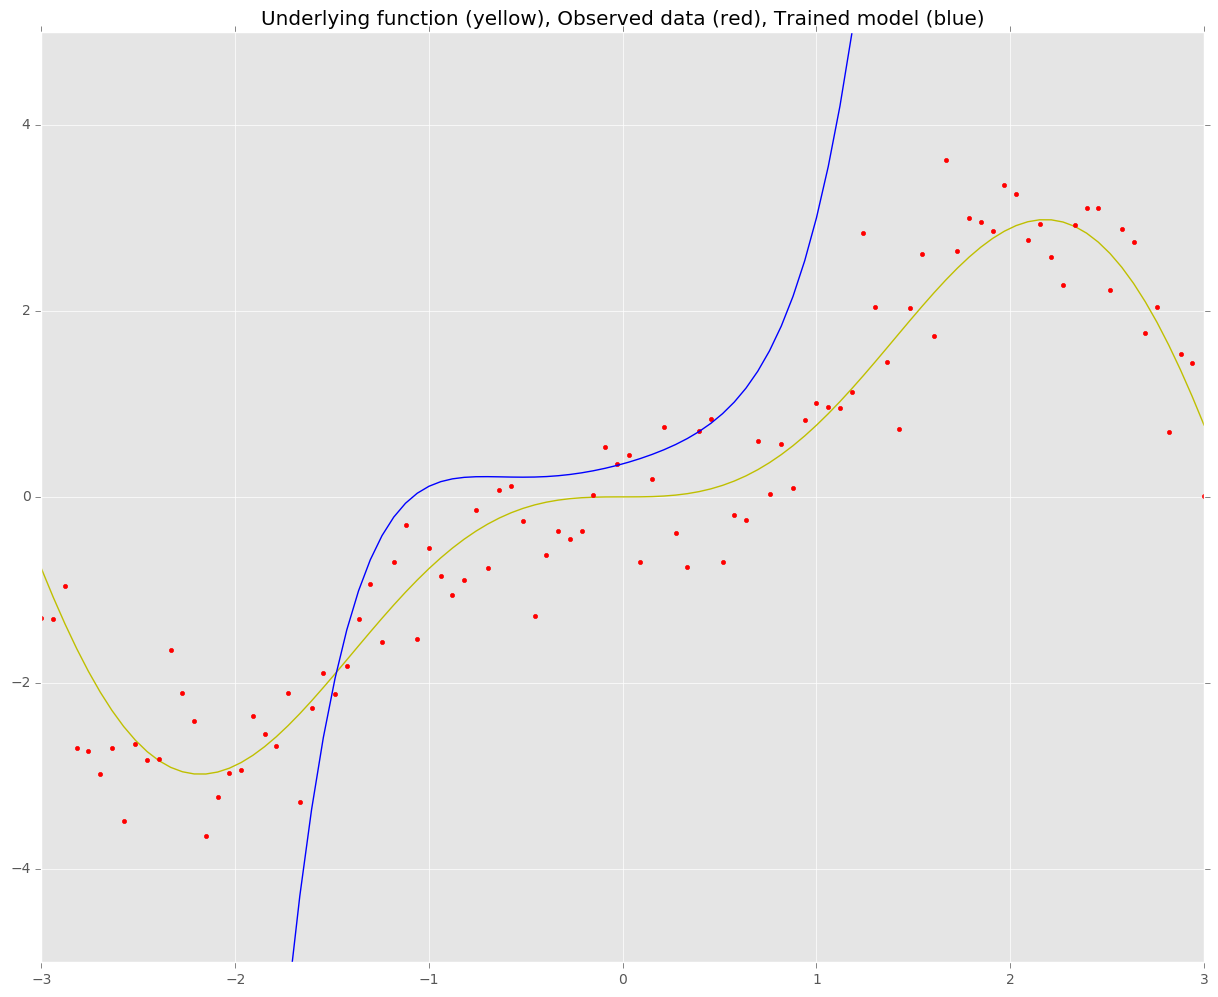

In [61]:
#Here is the code template you can use to implement algorithm
iters = 100

def compute_loss(y_train, y_pred, N=num_samples):
    diff = y_pred - y_train
    loss = np.dot(diff.T, diff)*1.0/N
    return loss

def compute_gradient(X, w, y, N=num_samples):
    grad = (np.dot(np.dot(X.T, X), w) - np.dot(X.T, y))*1.0/N
    return grad

def train(X,y_train,p,lr, max_iter = 100): #p is the degree of the polynomial
    losses = []
    w = np.random.rand(p+1,1)
    for i in range(max_iter):
        y_pred = np.dot(X,w)
        loss = compute_loss(y_train, y_pred)
        
        losses.append(loss) #you can use this to plot and see how the training progressed
        w = w - lr*compute_gradient(X, w, y_pred)
        
        #Here you can add checks to see if the loss changes or weight changes are below threshold, and break
        #Not critical for this problem
    
    w_best = w
    return w_best,losses


w_best,losses = train(X,y_train,5,0.01,iters)
y_pred = np.dot(X,w_best)


plt.plot(x,y_true,'y')
plt.plot(x,y_observed,'r.')
plt.plot(x,y_pred,'b')
plt.ylim([-5,5])
plt.title("Underlying function (yellow), Observed data (red), Trained model (blue)")
plt.show()

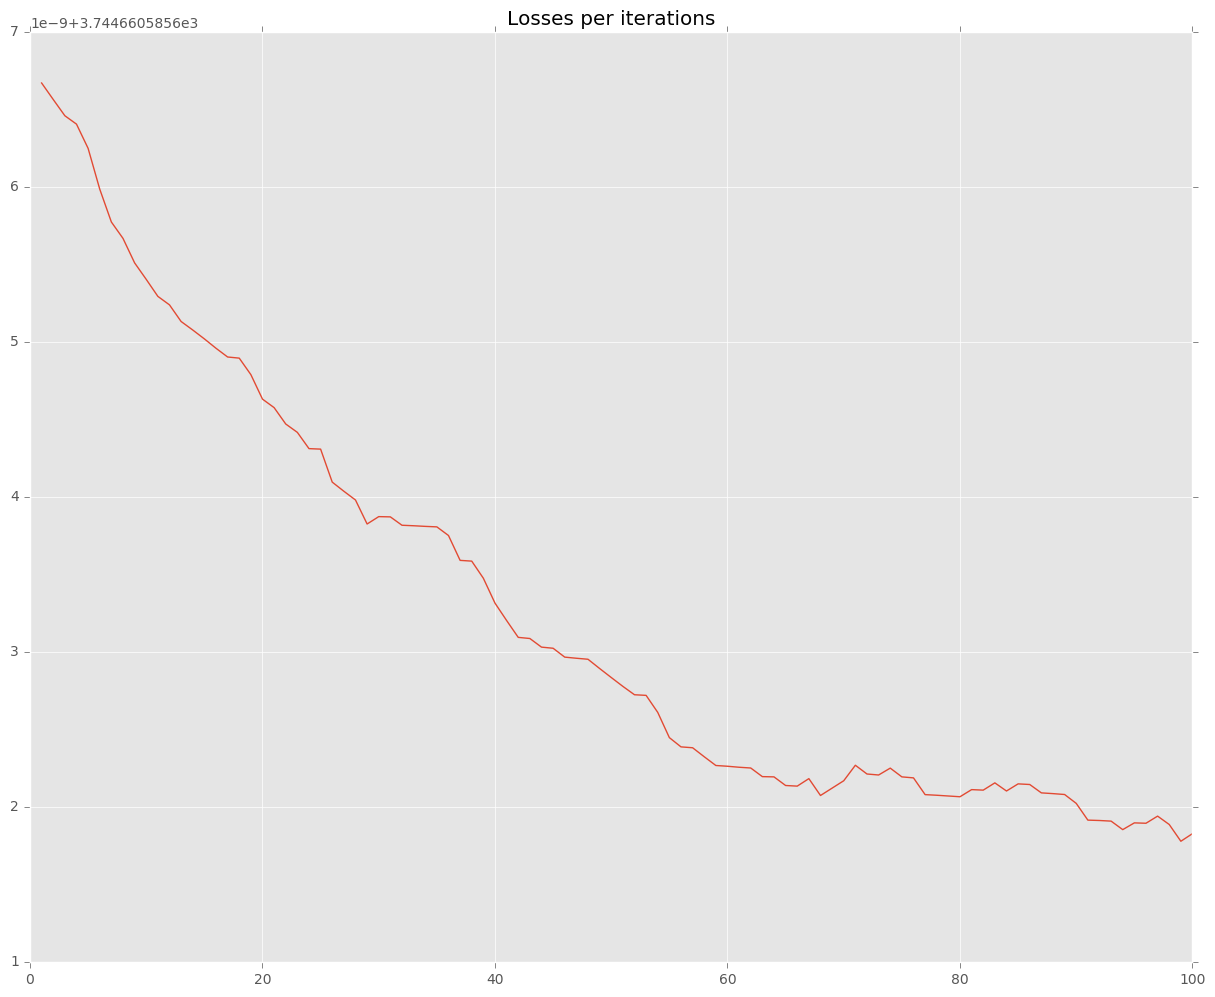

In [62]:
"""You can implement the code to plot the losses and study how the loss decreases after each iteration."""
iterations = np.linspace(1, iters, num=iters).reshape(-1, 1)
l = []
[l.append(e[0][0]) for e in losses]
l = np.array(l).reshape(-1,1)

plt.plot(iterations, l)
plt.title("Losses per iterations")
plt.show()